<a href="https://colab.research.google.com/github/Polaris1224/Machine-Learning/blob/main/Fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [6]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
print(df_true.shape)
print(df_fake.shape)

(21417, 4)
(23481, 4)


In [7]:
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
df.drop(columns = ['date'], inplace = True)

In [11]:
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [12]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [13]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [15]:
def preprocess(text):
  result = []
  #gensim.utils.simple_preprocess : Break text into words
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3 and token not in stop_words:
      result.append(token)
  return result

In [16]:
text = "This is an example text about NLP and preprocessing from a subject!"
# Preprocess the text
processed_text = preprocess(text)
print(processed_text)

['example', 'text', 'nlp', 'preprocessing']


In [17]:
df['clean'] = df['original'].apply(preprocess)

In [18]:
list_of_words = []
for i in df['clean']:
  for j in i:
    list_of_words.append(j)

In [19]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay',
 'tax',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'way',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'cbs',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'big',
 'budget',
 'increase',
 'military',
 'spending',
 '

In [20]:
len(list_of_words)

9792696

In [21]:
total_words = len(list(set(list_of_words)))
total_words

113950

In [22]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [23]:
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, let, mueller, jo...",senior republican senator let mueller job wash...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


In [24]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot way republicans representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increases non defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase non defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats s

###Visualization

In [25]:
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, let, mueller, jo...",senior republican senator let mueller job wash...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


<Axes: xlabel='count', ylabel='subject'>

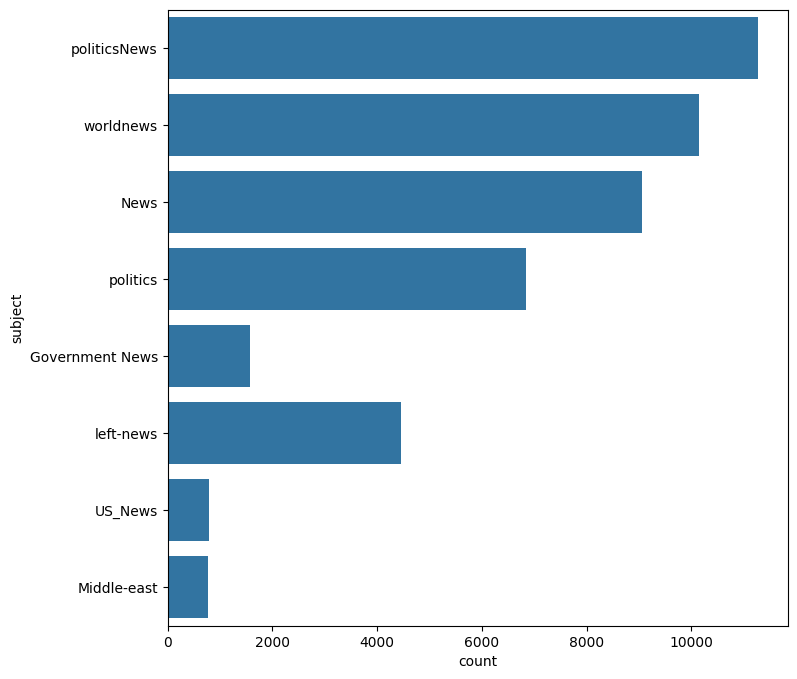

In [26]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

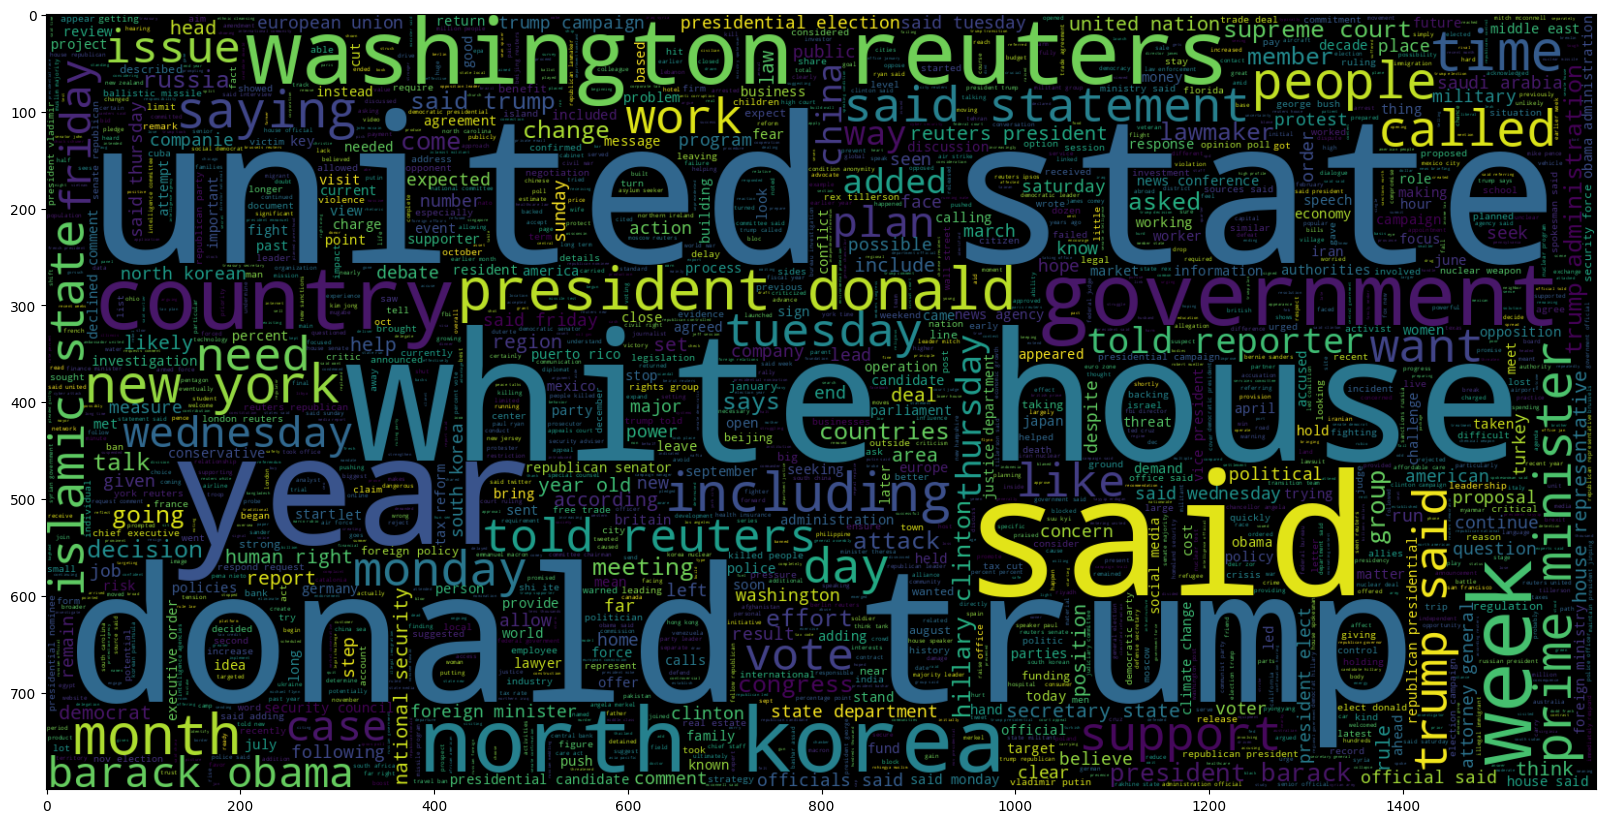

In [27]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

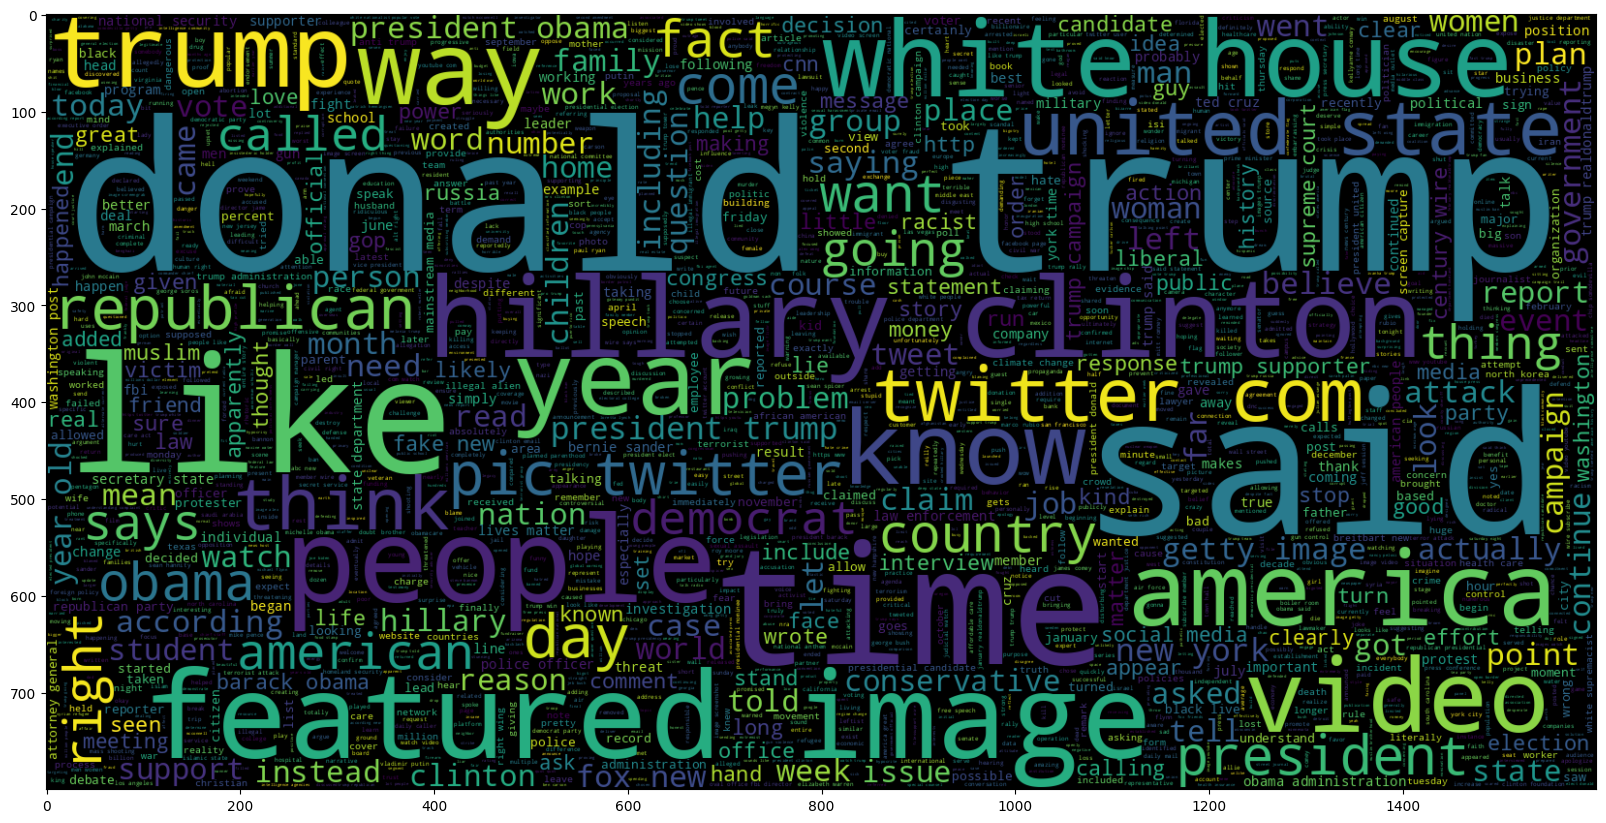

In [28]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

###Data By Performing Tokenization and Padding

Tokenizer : it allows as to vectorize text corpus by tuning each text into sequence of integers.

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_joined'], df['isfake'], test_size = 0.2, random_state = 42)

In [32]:
from nltk import word_tokenize

In [34]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

In [36]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequence[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot way republicans representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increases non defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase non defense discretionary spending percent meadows chairman small influential house freedom caucu

In [39]:
padded_train = pad_sequences(train_sequence,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequence,maxlen = 40, truncating = 'post')

In [40]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [   25  1029  1030    25  3305   894  3008   271   149    96   969    25
  1029  3816  1226   177  1282  1328   112    25  8201     8  7139 10590
   894  5604 20880    25 44945  5261 31821   149  7571     8 19878  1567
  2188     8    20     2]
The padded encoding for document 2  is :  [ 151  173  493    6 2807  696  244  783   10  151  252  277 2071  207
   13  173 2260   49   93 1845  154 4429  358  280 2807 2326  244  918
  512  268    2   85  151  911  257   88 3485  993   95  376]


In [42]:
model = Sequential()
model.add(Embedding(total_words, output_dim = 128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
total_words

113950

In [44]:
y_train = np.asarray(y_train)

In [45]:
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 203s 389ms/step - acc: 0.9426 - loss: 0.1119 - val_acc: 0.9989 - val_loss: 0.0060
Epoch 2/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 195s 385ms/step - acc: 0.9998 - loss: 0.0015 - val_acc: 0.9992 - val_loss: 0.0064


In [47]:
pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step


In [48]:
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [49]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9972160356347439


<Axes: >

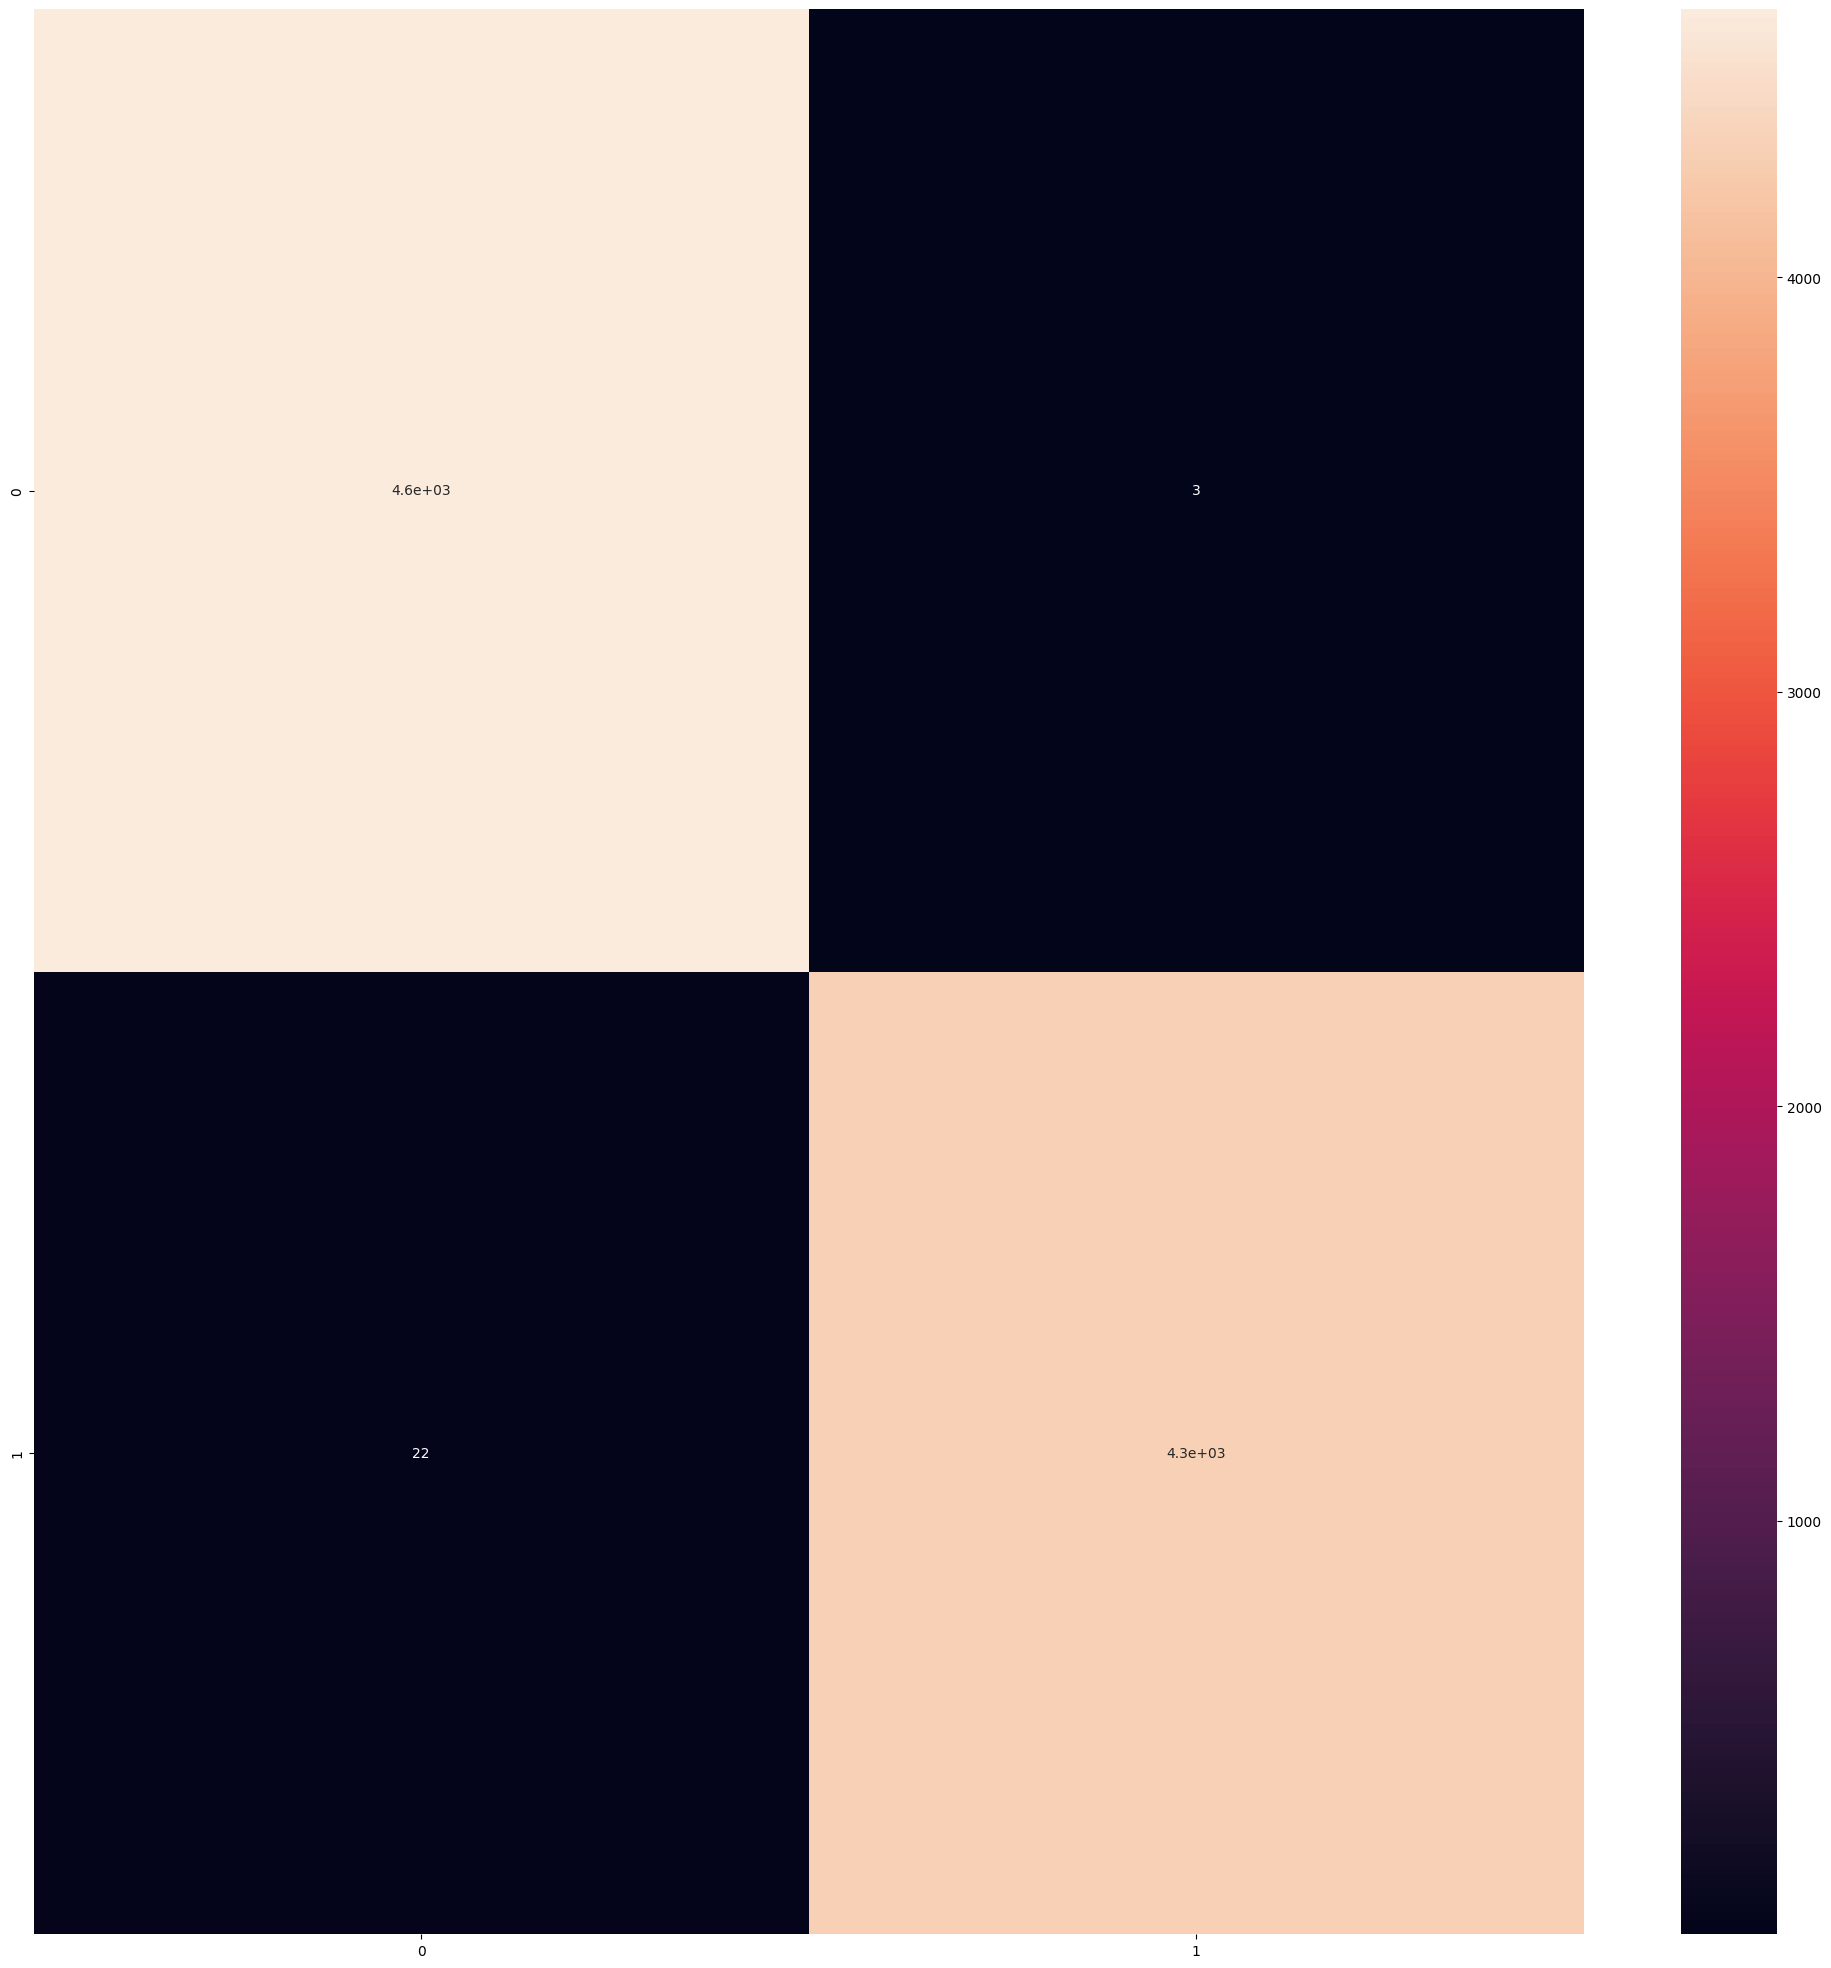

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [51]:
category = { 0: 'Fake News', 1 : "Real News"}

In [52]:
df_true
df_fake
df_true.info()
df_fake.info()
df_true.isnull().sum()
df_fake.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   isfake   21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   isfake   23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


,0
title,0
text,0
subject,0
date,0
isfake,0


In [54]:
df['original'][5]
df['clean_joined'][5]

'white house congress prepare talks spending immigration west palm beach fla washington reuters white house said friday set kick talks week republican democratic congressional leaders immigration policy government spending issues need wrapped early new year expected flurry legislative activity comes republicans democrats begin set stage midterm congressional elections november president donald trump republican party eager maintain control congress democrats look openings wrest seats away senate house representatives wednesday trump budget chief mick mulvaney legislative affairs director marc short meet senate majority leader mitch mcconnell house speaker paul ryan republicans democratic counterparts senator chuck schumer representative nancy pelosi white house said followed weekend strategy sessions trump mcconnell ryan jan camp david presidential retreat maryland according white house senate returns work jan house jan congress passed short term government funding week taking christmas

<Axes: xlabel='count', ylabel='isfake'>

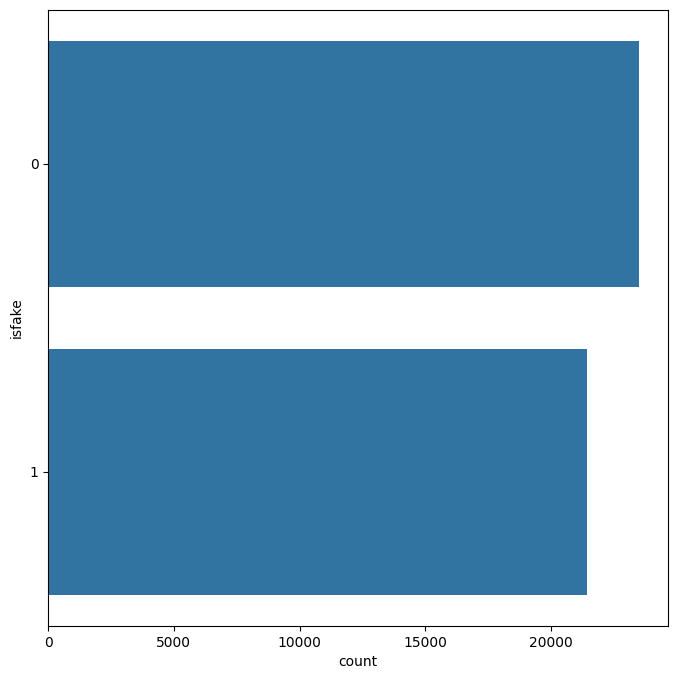

In [53]:
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

In [65]:
def predict_news(text):
    processed_text = preprocess(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=40, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    category_index = (prediction > 0.5).astype(int)[0][0]
    news_category = category[category_index]

    return news_category

a = predict_news("WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: “As mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.” Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal “great news.” “I’m hoping it means the government has come to see that there is no way to justify a ban and that it’s not good for the military or our country,” Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obama’s policy of accepting them. Trump said on Twitter at the time that the military “cannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.” Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trump’s ban while legal challenges to the Republican president’s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicants’ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept “some individuals who are not medically fit for service.” The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trump’s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the president’s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity.")
print(a)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Real News
